In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/My Drive/Wave_propogation

/content/drive/My Drive/Wave_propogation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

import torch
from PIL import Image
import torchvision.transforms as transforms

# from utils import  Simulation, get_vp, ParamsGenerator

from train_utils import get_batch, train, validate, test
from plottings import show_grig
from IPython.display import clear_output
from time import gmtime, strftime
%load_ext autoreload
%autoreload 2

In [3]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=f79b3f84c3188798621973add58f81dd6c3c1d50fd26ae190f3ea6fb3446e44f
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [4]:
N_min = 4.
N_max = 6.

nx, nz, nt = 150, 150, 1000

n_rows = 2

batch = get_batch_AE( N_min, N_max, nx, nz, nt, n_rows ** 2)

NameError: ignored

In [23]:
# batch['u_vp'].shape, batch['q'].shape, batch['dd'].shape

In [22]:
# for i in range(1, 1000, 10):
#   show_grig(batch[0][1, i, :, :][None], 1)

In [21]:
# show_grig(batch[1][:, 0, :, :], n_rows)

In [20]:
# for i in range(len(batch[1][:, 0, :, :])):
#   _, s,_ = np.linalg.svd(batch[1][i, 0, :, :])

#   plt.plot(s/s.max())
#   plt.yscale('log')
#   plt.show()

# for i in range(len(batch[2][:, -1, :, :])):
#   _, s,_ = np.linalg.svd(batch[1][i, -1, :, :])

#   plt.plot(s/s.max())
#   plt.yscale('log')
#   plt.show()

In [5]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [6]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
device

'cpu'

In [16]:
from models import WaveAE, WaveGRUModel
import torch, torch.nn as nn
import GPUtil

N_min = 4.
N_max = 6.

nx, nz, nt = 80, 80, 50

#model = WaveAE(in_channels=1, bottle_neck=32, n_layers=2, kernel_size=3,
#               pooling=nn.MaxPool2d, activation=nn.ELU, pruning=True)

model = WaveGRUModel(bottle_neck=32, n_layers=2, kernel_size=3,
               pooling=nn.MaxPool2d, activation=nn.ELU, pruning=True, mode='fooo')

model.to(device)

#loss = nn.MSELoss()
loss = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)

#GPUtil.showUtilization()

In [17]:
batch_size = 2
n_epochs = 200
n_batches_per_epoch = 10
n_validation_batches = 5

In [18]:
import gc
del batch
gc.collect()
torch.cuda.empty_cache()

#GPUtil.showUtilization()

NameError: ignored

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


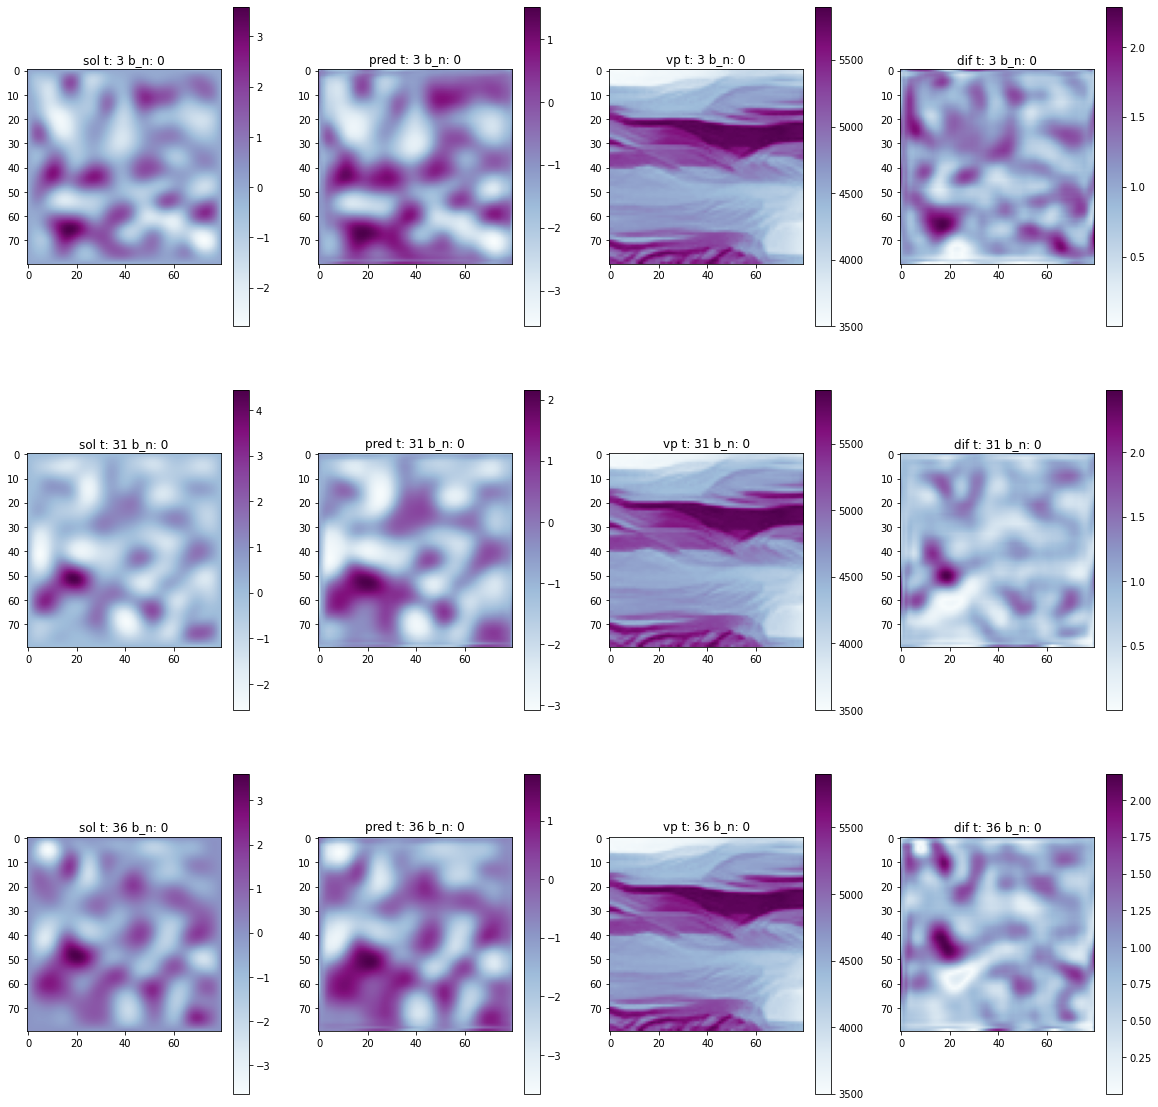

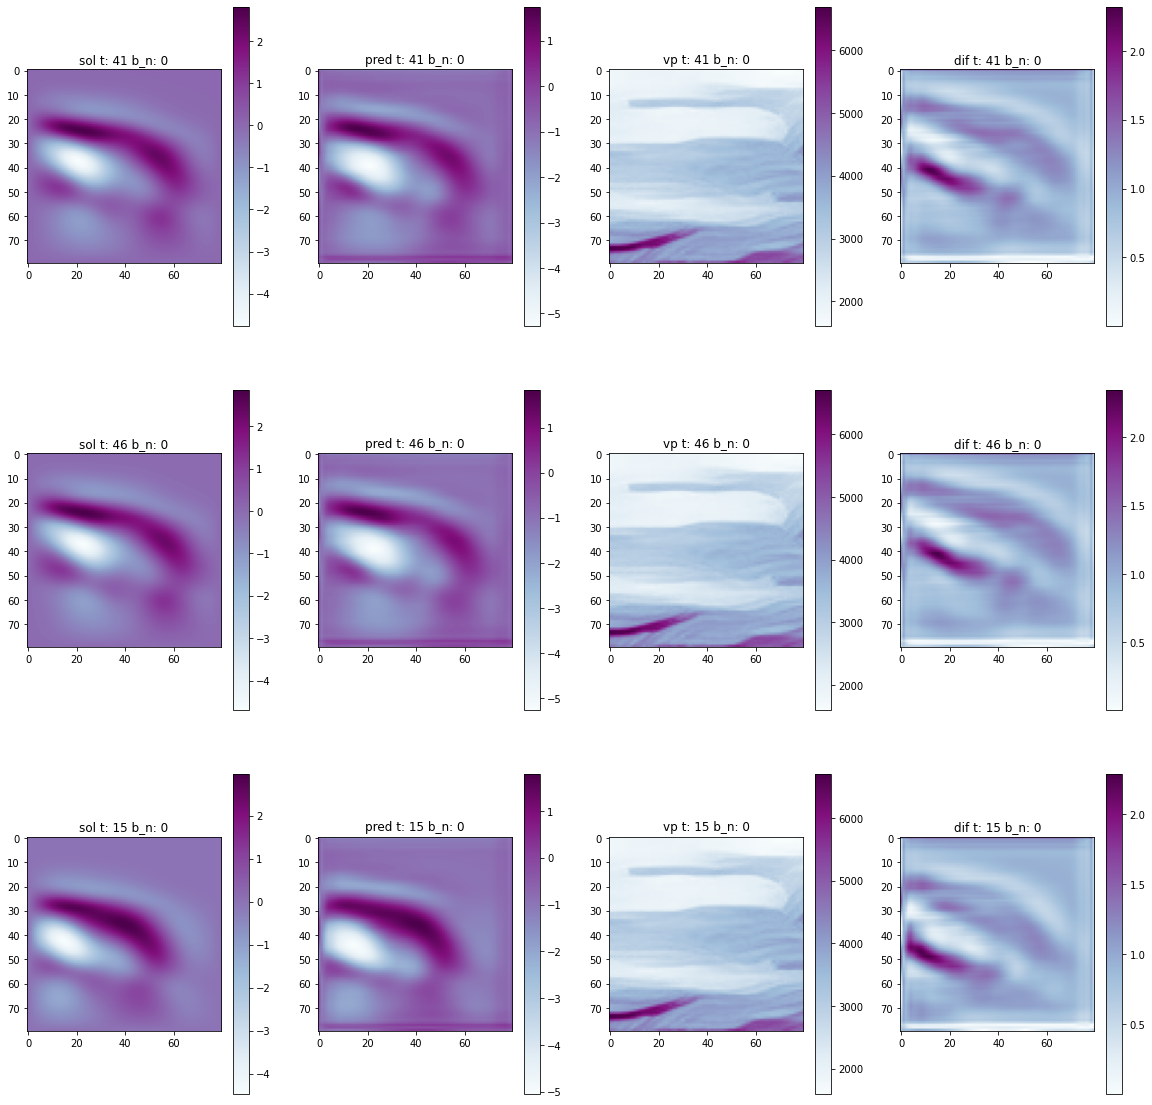


Epoch: 1, train loss: 0.33631970435380937, val loss: 0.47223034501075745
Time for NN = 0.319302, Time for FD = 0.115424
(tensor(23.6111), 144, tensor([0.0832], grad_fn=<SigmoidBackward>))
(tensor(100.), 4608, tensor([0.0975], grad_fn=<SigmoidBackward>))
(tensor(15.9722), 144, tensor([0.0600], grad_fn=<SigmoidBackward>))
(tensor(6.8576), 4608, tensor([0.0031], grad_fn=<SigmoidBackward>))
(tensor(84.2448), 4608, tensor([0.0678], grad_fn=<SigmoidBackward>))
(tensor(2.7778), 144, tensor([0.0047], grad_fn=<SigmoidBackward>))
(tensor(100.), 36864, tensor([0.0606], grad_fn=<SigmoidBackward>))
(tensor(31.7925), 18432, tensor([0.0102], grad_fn=<SigmoidBackward>))


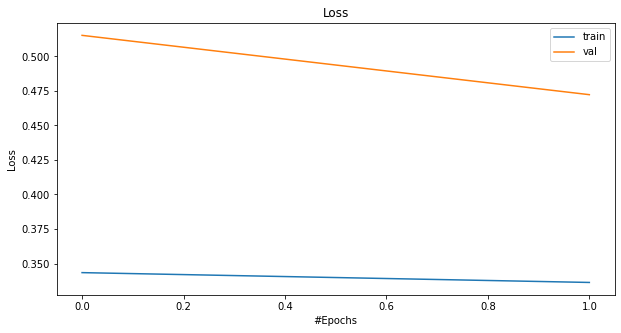

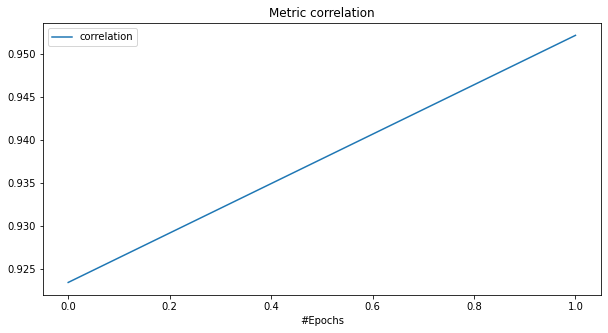

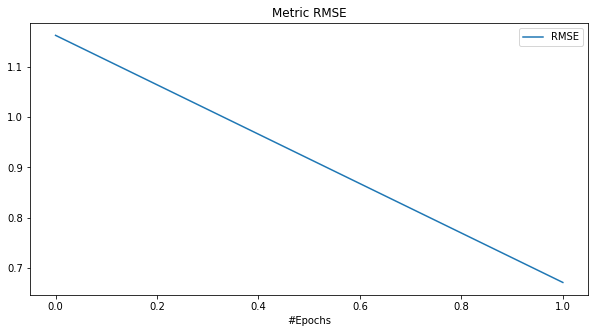




...
KeyboardInterrupt error: model saving started!
Parameters of the model and optimizer are saved to file --> ./checkpoints/WaveGRUModel2020-11-20 00:46:25.pth


In [24]:
from plottings import plot_metrics
loss_hist = {'train': [],
             'val': []}

metrix_coeff = {'correlation': [],
                'RMSE': []}

epoch_time_nn = []
epoch_time_fd = []

try :
  for epoch in tqdm(range(n_epochs)):
    
    train(model, optimizer, loss_hist, epoch_time_nn, N_min, N_max, nx, nz, nt,
            epoch_time_fd, n_batches_per_epoch, batch_size, device, loss)
    
    # clear_output()

    validate(model, optimizer, loss_hist, n_validation_batches, 
            device, N_min, N_max, nx, nz, nt, loss, batch_size, metrix_coeff)
    
    plot_metrics(model, epoch, loss_hist, epoch_time_nn, epoch_time_fd, metrix_coeff)

except KeyboardInterrupt:
  print('\n\n\n...\nKeyboardInterrupt error: model saving started!')
  
  state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict(), 'loss_hist': loss_hist}
  file_name = './checkpoints/' + model.__class__.__name__ + strftime("%Y-%m-%d %H:%M:%S", gmtime()) + '.pth'
  torch.save(state, file_name)

  print('Parameters of the model and optimizer are saved to file --> ' + file_name)


Epoch: 2, train loss: 0.32063104063272474, val loss: 0.4164005219936371
Time for NN = 0.029603, Time for FD = 0.125505
(tensor(2.0833), 144, tensor([0.0070], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(100.), 4608, tensor([0.1115], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(9.0278), 144, tensor([0.0204], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(21.3542), 4608, tensor([0.0148], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(9.7222), 4608, tensor([0.0056], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(3.4722), 144, tensor([0.0077], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(20.9310), 36864, tensor([0.0045], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(71.0992), 18432, tensor([0.0268], device='cuda:0', grad_fn=<SigmoidBackward>))


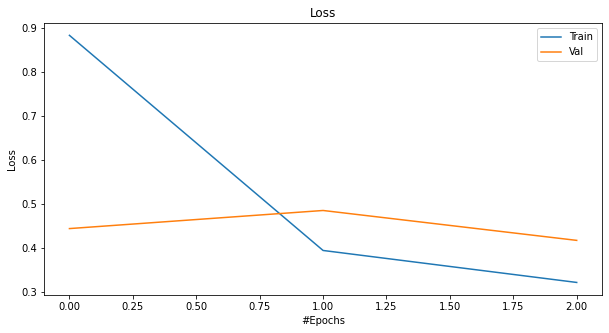

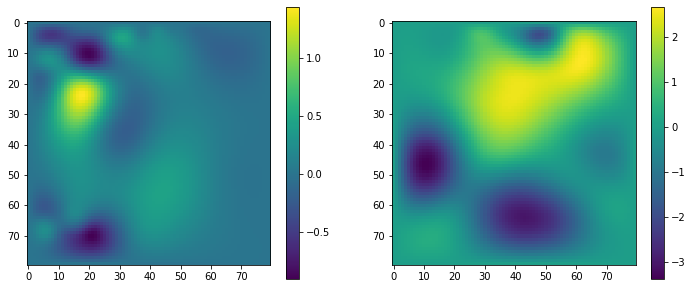

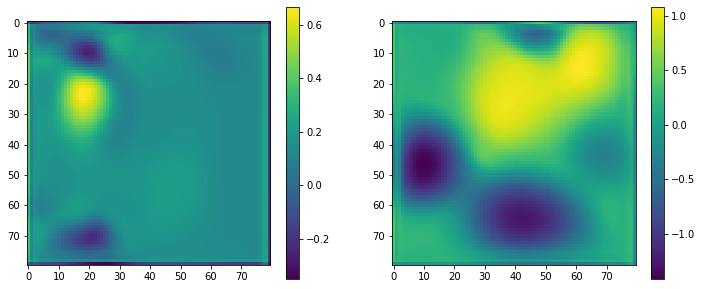

torch.Size([2, 49, 80, 80])
torch.Size([2, 49, 32, 20, 20])
torch.Size([98, 1, 80, 80])
0.02662944793701172 0.19327139854431152


KeyboardInterrupt: ignored

In [ ]:
# from tqdm.notebook import tqdm
# from IPython.display import clear_output
# import time


# loss_hist = {'train': [],
#              'val': []}

# epoch_time_nn = []
# epoch_time_fd = []

# for epoch in tqdm(range(n_epochs)):
    
#     train_loss=0
#     model.train(True)
#     t_nn = 0.
#     t_fd = 0.
#     for _ in tqdm(range(n_batches_per_epoch)):
#         if model.model_type == 'AE':
#           batch = get_batch(N_min, N_max, nx, nz, nt, batch_size)
#         else:
#           #raise NotImplementedError('RNN to be continued')
#           batch = get_batch(N_min, N_max, nx, nz, nt, batch_size)
#         optimizer.zero_grad()
        
#         factor = batch['u_vp'][:, :-1, 0, :, :].std()

#         X = torch.from_numpy(batch['u_vp']).float()
#         X[:, :, 0, :, :] /= factor
#         #GPUtil.showUtilization()
#         #boundaries = torch.tensor(batch[1], dtype=torch.float32).to(device)
#         #GPUtil.showUtilization()
#         #Y = torch.tensor(batch[2] /f actor, dtype=torch.float32).to(device)
#         #GPUtil.showUtilization()
#         start = time.time()
        
#         #predictions = model(X[:, :-1, 0, :, :].unsqueeze(2).to(device))
        
#         predictions = model(X[:, :-1, 0, :, :].to(device), X[:, 0, 0, :, :].unsqueeze(1).to(device))  
#         t_nn += (time.time() - start) / batch_size
#         t_fd += batch['exec_time']
        
#         print(t_nn, t_fd)
#         #print(predictions.shape, X[:, 1: , 0, :, :].shape)

#         loss_t = loss(predictions, X[:, 1: , 0, :, :].to(device))
        
#         #GPUtil.showUtilization()
#         loss_t.backward()

#         # print('============================')
#         # for p in model.parameters():  
#         #   print(p.shape, p.grad.sum())
#         #   if p.shape == torch.Size([1]):
#         #     print(p)


#         optimizer.step()
        
#         train_loss += loss_t.item()
        
#         del X, predictions
#         gc.collect()
#         torch.cuda.empty_cache()
        
#     epoch_time_nn.append(t_nn / n_batches_per_epoch)
#     epoch_time_fd.append(t_fd / n_batches_per_epoch)

#     train_loss /= n_batches_per_epoch
    
#     loss_hist['train'].append(train_loss)
    
    
#     val_loss=0
#     model.train(False)
#     for _ in tqdm(range(n_validation_batches)):
        
#         if model.model_type == 'AE':
#           batch = get_batch(N_min, N_max, nx, nz, nt, batch_size)
#         else:
#           batch = get_batch(N_min, N_max, nx, nz, nt, batch_size)
#           #raise NotImplementedError('RNN to be continued')
#         optimizer.zero_grad()
        
#         factor = batch['u_vp'][:, :-1, 0, :, :].std()

#         X = torch.from_numpy(batch['u_vp']).float()
#         X[:, :, 0, :, :] /= factor

#         #predictions = model(X[:, :-1, 0, :, :].to(device))
#         predictions = model(X[:, :-1, 0, :, :].to(device), X[:, 0, 0, :, :].unsqueeze(1).to(device))
#         loss_t = loss(predictions, X[:, 1: , 0, :, :].to(device))  
        
#         val_loss += loss_t.item()

#     val_loss /= n_validation_batches
    
#     loss_hist['val'].append(val_loss)
    
#     if epoch !=0:
#       clear_output()
#       print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
#       print('Time for NN = %f, Time for FD = %f' % (epoch_time_nn[-1], epoch_time_fd[-1]))
#       model.compression()
#       plt.figure(figsize=(10, 5))
#       plt.plot(loss_hist['train'], label='Train')
#       plt.plot(loss_hist['val'], label='Val')
#       plt.xlabel('#Epochs')
#       plt.ylabel('Loss')
#       plt.title('Loss')
#       plt.legend(loc='best')
#       plt.show()

#       plt.figure(figsize=(12, 5))
#       plt.subplot(1, 2, 1)
#       plt.imshow(X[0, -1 , 0, :, :])
#       plt.colorbar()
#       plt.subplot(1, 2, 2)
#       plt.imshow(X[1, -1 , 0, :, :])
#       plt.colorbar()
#       plt.show()
      

#       plt.figure(figsize=(12, 5))
#       plt.subplot(1, 2, 1)
#       plt.imshow(predictions[0, -1, :, :].cpu().data.numpy())
#       plt.colorbar()
#       plt.subplot(1, 2, 2)
#       plt.imshow(predictions[1, -1, :, :].cpu().data.numpy())
#       plt.colorbar()
#       plt.show()

#       del X, predictions
#       gc.collect()
#       torch.cuda.empty_cache()

# print("Finished!")

In [ ]:
for p in model.parameters():
  print(p)

Parameter containing:
tensor([-5.5466], requires_grad=True)


Parameter containing:
tensor([[[[-6.0474e-03, -1.4645e-01, -1.8398e-01],
          [-1.3833e-01,  7.5898e-02,  2.2747e-01],
          [ 2.2963e-01, -5.5039e-02,  2.1421e-01]]],


        [[[-1.6198e-01,  9.4133e-02, -8.2062e-02],
          [ 2.5626e-01,  7.9030e-02,  2.5544e-01],
          [ 1.0069e-01,  7.3927e-02,  1.0194e-01]]],


        [[[ 2.9883e-01, -6.5145e-02,  1.8842e-01],
          [ 7.7682e-02, -5.7862e-02,  1.8398e-01],
          [ 3.2494e-01, -8.7152e-02,  2.2963e-02]]],


        [[[-1.2237e-01,  1.0229e-01,  1.2140e-02],
          [ 1.3549e-01, -6.4051e-02,  1.3258e-01],
          [-2.0563e-01,  1.7227e-01, -2.7927e-02]]],


        [[[ 1.6490e-01,  9.2606e-02, -1.1274e-01],
          [ 2.7935e-04,  1.2115e-01,  1.2333e-01],
          [-1.7973e-01, -2.1941e-01,  2.0240e-01]]],


        [[[ 2.8050e-01,  4.4532e-02,  2.0747e-01],
          [-9.6070e-02, -9.5489e-02,  2.2923e-01],
          [-2.2716e-01, -2.42

In [ ]:
import gc
del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  8% |


In [ ]:
batch[0].max()

1.247313496499323e-07

In [ ]:
#torch.save(model.state_dict(), './AE_maxpool_relu.pth')

NameError: ignored